In [ ]:
# !pip install fasttext

In [ ]:
# !pip install gensim

In [ ]:
!pip install sastrawi

In [ ]:
from datasets import load_dataset
import re, time, torch, torch.nn as nn
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
import seaborn as sns

In [ ]:
#prerocessing
from collections import OrderedDict

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from datetime import datetime

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Nilam
path = "/content/drive/MyDrive/MKA/semester 2/PMML/Before UTS/Tugas Kelompok PMML/Backup-data/"

In [ ]:
#atika
path = "/content/drive/MyDrive/coba/"

In [ ]:
data_full = pd.read_excel(path + "Komentar Tiktok IKN Data.xlsx")

In [ ]:
data_full.head()

,text,label
0,ikn ibukota koruptor nepotisme,negatif
1,sy mau tanya ikn itu untuk apa trs yg menempat...,negatif
2,bapak skolahin anak nya yg setinggi nnti bsa n...,negatif
3,wacana belim ada kesitu realnya dan faktanya a...,negatif
4,follow ig ikn pak udh dr lama kq buka lowongan...,negatif


In [ ]:
print(data_full['label'].value_counts())

label
negatif    780
positif    692
Name: count, dtype: int64


# Cleansing

In [ ]:
data_full['text_clean'] = data_full['text'].apply(lambda teks: teks.lower())
data_full.head()

,text,label,text_clean
0,ikn ibukota koruptor nepotisme,negatif,ikn ibukota koruptor nepotisme
1,sy mau tanya ikn itu untuk apa trs yg menempat...,negatif,sy mau tanya ikn itu untuk apa trs yg menempat...
2,bapak skolahin anak nya yg setinggi nnti bsa n...,negatif,bapak skolahin anak nya yg setinggi nnti bsa n...
3,wacana belim ada kesitu realnya dan faktanya a...,negatif,wacana belim ada kesitu realnya dan faktanya a...
4,follow ig ikn pak udh dr lama kq buka lowongan...,negatif,follow ig ikn pak udh dr lama kq buka lowongan...


In [ ]:
data_full['text_clean'].duplicated().sum()

np.int64(1)

In [ ]:
data_full['text_clean'].drop_duplicates(inplace = True)
data_full.drop_duplicates(subset=['text_clean'], inplace=True)
data_full['text_clean'].duplicated().sum()

np.int64(0)

In [ ]:
def remove_hashtag(komentar):
  hashtag = re.sub(r'#\w+', "", komentar)
  return hashtag

def remove_add(komentar):
  hashtag = re.sub(r'@\w+', "", komentar)
  return hashtag

def remove_number(komentar):
  num = re.sub(r'\d+', " ", komentar)
  return num

def remove_punctuation(komentar):
  list_punct = string.punctuation
  delete_punct = str.maketrans(list_punct,' '*len(list_punct))
  new_review = ' '.join(komentar.translate(delete_punct).split())
  return new_review

def remove_superscript(komentar):
  number = re.compile("["u"\U00002070"
                      u"\U000000B9"
                      u"\U000000B2-\U000000B3"
                      u"\U00002074-\U00002079"
                      u"\U0000207A-\U0000207E"
                      u"U0000200D"
                      "]+", flags=re.UNICODE)
  return number.sub(r'', komentar)

def char_repetition(komentar):
  review = re.sub(r'(.)\1+', r'\1\1', komentar)
  return review

def remove_extra_whitespaces(komentar):
  review = re.sub(r'\s+',' ', komentar)
  return review

def remove_username_word(komentar):
    remove_username = re.sub(r'(?i)\busername\b', '', komentar)
    return remove_username

def remove_banned_words(komentar):
    bannedword = ['uqjy', 'dehdje', 'jwdnmb', 'wxvlezuvws', 'ircel', 'swjjw', 'dmv',
         'dxrgz','qjtajuq','zzhwntdft','xywrfw' ,'fztnmdrrduy' ,'xsezuz',
         'kbyv', 'iyyveyzqkdgm', 'arlrmdjy', 'sfarif', 'sfomar',
         'syantienurxsayurbox', 'ghinaxsayurbox', 'nzxx', 'mtsco','wkwk',
         'wkwkw','wkwkwk','hihi','hihihii','hihihi','hehehe','hehehehe','hehe',
         'huhu','huhuu','ancok','guak','cokcok','hhmm','annya','huftt']
    re_banned_words = re.compile(r"\b(" + "|".join(bannedword) + ")\\W", re.I)
    return re_banned_words.sub("", komentar)

def remove_links(komentar):
    return re.sub(r'http\S+|www\S+|https\S+', '', komentar)

In [ ]:
# data_full['text_clean'] = data_full['text_clean'].apply(lambda hashtag: remove_hashtag(hashtag))
# data_full['text_clean'] = data_full['text_clean'].apply(lambda hashtag: remove_add(hashtag))
# data_full['text_clean'] = data_full['text_clean'].apply(lambda number: remove_number(number))
# data_full['text_clean'] = data_full['text_clean'].apply(lambda punc: remove_punctuation(punc))
# data_full['text_clean'] = data_full['text_clean'].apply(lambda sup: remove_superscript(sup))
# data_full['text_clean'] = data_full['text_clean'].apply(lambda char: char_repetition(char))
# data_full['text_clean'] = data_full['text_clean'].apply(lambda space: remove_extra_whitespaces(space))
# data_full['text_clean'] = data_full['text_clean'].apply(lambda username: remove_username_word(username))
# data_full['text_clean'] = data_full['text_clean'].apply(lambda banned: remove_banned_words(banned))
# data_full['text_clean'] = data_full['text_clean'].apply(lambda link: remove_links(link))
# data_full.head()

# steamming + stopword

In [ ]:
#steaming
start_time = datetime.now()

factory = StemmerFactory()
stemmer = factory.create_stemmer()

data_full['text_clean_steam'] = data_full['text'].apply(lambda x: stemmer.stem(x))
data_full.head()

end_time = datetime.now()
print('Waktu yang diperlukan: {}'.format(end_time - start_time))

Waktu yang diperlukan: 0:02:58.698785


In [ ]:
#stopword
factory = StopWordRemoverFactory()
list_stopword = factory.get_stop_words()
len(list_stopword)

126

In [ ]:
#stopword
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

data_full['text_stp_sastrawi'] = data_full['text_clean_steam'].apply(lambda x: " ".join(stopword.remove(x) for x in x.split() ))
data_full.head()

,text,label,text_clean,text_clean_steam,text_stp_sastrawi
0,ikn ibukota koruptor nepotisme,negatif,ikn ibukota koruptor nepotisme,ikn ibukota koruptor nepotisme,ikn ibukota koruptor nepotisme
1,sy mau tanya ikn itu untuk apa trs yg menempat...,negatif,sy mau tanya ikn itu untuk apa trs yg menempat...,sy mau tanya ikn itu untuk apa trs yg tempat i...,sy mau tanya ikn apa trs yg tempat ikn rakya...
2,bapak skolahin anak nya yg setinggi nnti bsa n...,negatif,bapak skolahin anak nya yg setinggi nnti bsa n...,bapak skolahin anak nya yg setinggi nnti bsa n...,bapak skolahin anak nya yg setinggi nnti bsa n...
3,wacana belim ada kesitu realnya dan faktanya a...,negatif,wacana belim ada kesitu realnya dan faktanya a...,wacana belim ada kesitu real dan fakta aja jan...,wacana belim kesitu real fakta aja jangan ng...
4,follow ig ikn pak udh dr lama kq buka lowongan...,negatif,follow ig ikn pak udh dr lama kq buka lowongan...,follow ig ikn pak udh dr lama kq buka lowong t...,follow ig ikn pak udh dr lama kq buka lowong t...


# Split data

In [ ]:
from sklearn.model_selection import train_test_split

X = data_full["text_clean_steam"]
y = data_full["label"]

# Split pertama: Train (70%) + Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split kedua: Validation (15%) + Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))


Train: 1029
Validation: 221
Test: 221


In [ ]:
df_train = pd.DataFrame({"text": X_train, "label": y_train})
df_val   = pd.DataFrame({"text": X_val, "label": y_val})
df_test  = pd.DataFrame({"text": X_test, "label": y_test})


# **LSTM + IndoBert**

IndoBERT Tokenizer + Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model_name = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
indobert = AutoModel.from_pretrained(model_name).to(device)
indobert.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31923, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

function to encode with IndoBERT

In [ ]:
def bert_encode(texts, tokenizer, model, device, max_len=128, batch_size=32):
    embeddings = []
    loader = DataLoader(texts, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for batch_texts in loader:
            enc = tokenizer(
                list(batch_texts),
                truncation=True, padding="max_length",
                max_length=max_len, return_tensors="pt"
            )
            input_ids = enc["input_ids"].to(device)
            attention_mask = enc["attention_mask"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            seq_emb = outputs.last_hidden_state   # [batch, seq_len, 768]
            embeddings.append(seq_emb.cpu())
    return torch.cat(embeddings, dim=0)

In [ ]:
print("Encoding dataset with IndoBERT...")
X_train_bert = bert_encode(df_train["text"].tolist(), tokenizer, indobert, device)
X_val_bert   = bert_encode(df_val["text"].tolist(), tokenizer, indobert, device)
X_test_bert  = bert_encode(df_test["text"].tolist(), tokenizer, indobert, device)

Encoding dataset with IndoBERT...


In [ ]:
from sklearn.preprocessing import LabelEncoder
import torch

# Buat encoder dan fit hanya dari data train
le = LabelEncoder()
le.fit(df_train["label"])

# Transform label ke angka
y_train_bert = torch.tensor(le.transform(df_train["label"]), dtype=torch.long)
y_val_bert   = torch.tensor(le.transform(df_val["label"]), dtype=torch.long)
y_test_bert  = torch.tensor(le.transform(df_test["label"]), dtype=torch.long)

# Cek mapping label → angka
print("Mapping label:", dict(zip(le.classes_, le.transform(le.classes_))))
print("Contoh y_train_bert:", y_train_bert[:10])


Mapping label: {'negatif': np.int64(0), 'positif': np.int64(1)}
Contoh y_train_bert: tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 0])


LSTM Classifier

In [ ]:
class LSTMIndoBERT(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, output_dim=2, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)  # *2 karena bidirectional

    def forward(self, x):
        # x = [batch, seq_len, 768]
        _, (hidden, _) = self.lstm(x)   # hidden = [2, batch, hidden_dim]
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)  # gabung arah fw+bw
        out = self.fc(self.dropout(hidden_cat))
        return out
model_bert = LSTMIndoBERT().to(device)

In [ ]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_bert.parameters()),
    lr=1e-5,
    weight_decay=1e-4
)
criterion = nn.CrossEntropyLoss()
batch_size = 16
epochs = 100  # Tetapkan tinggi, Early Stopping akan berhenti lebih awal

train_losses, val_losses = [], []
train_accs, val_accs = [], []
# ===============================================
# Variabel Early Stopping berbasis Val Accuracy (tanpa min_delta)
# ===============================================
best_val_acc = 0.0        # akurasi validasi tertinggi
patience = 5         # berhenti kalau stagnan selama 10 epoch
patience_counter = 0
best_model_state = None
# ===============================================

for epoch in range(epochs):
    # ==========================
    # Training
    # ==========================
    model_bert.train()
    total_loss, correct, total = 0, 0, 0
    for i in range(0, len(X_train_bert), batch_size):
        x_batch = X_train_bert[i:i+batch_size].to(device)
        y_batch = y_train_bert[i:i+batch_size].to(device)

        optimizer.zero_grad()
        outputs = model_bert(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.max(outputs, 1)[1]
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / (len(X_train_bert) // batch_size)
    acc = correct / total

    # ==========================
    # Validation
    # ==========================
    model_bert.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for i in range(0, len(X_val_bert), batch_size):
            x_batch = X_val_bert[i:i+batch_size].to(device)
            y_batch = y_val_bert[i:i+batch_size].to(device)

            outputs = model_bert(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            predicted = torch.max(outputs, 1)[1]
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / (len(X_val_bert) // batch_size)
    val_acc = correct / total

    train_losses.append(avg_loss)
    train_accs.append(acc)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    # ==========================
    # Logika Early Stopping (tanpa min_delta)
    # ==========================
    is_best = ""
    if val_acc > best_val_acc:  # setiap kenaikan dianggap signifikan
        best_val_acc = val_acc
        best_model_state = model_bert.state_dict()
        patience_counter = 0
        is_best = " (BEST)"
    else:
        patience_counter += 1

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_loss:.4f} | Train Acc: {acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}{is_best}")

    if patience_counter >= patience:
        print(f"\nEarly Stopping: Val Accuracy tidak membaik selama {patience} epoch. Menghentikan pelatihan.")
        break

# ==========================
# Muat Model Terbaik
# ==========================
if best_model_state is not None:
    model_bert.load_state_dict(best_model_state)
    print("\nBobot model terbaik (berdasarkan Val Accuracy) telah dimuat untuk evaluasi.")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")



Epoch 1/100 | Train Loss: 0.7338 | Train Acc: 0.4859 | Val Loss: 0.7560 | Val Acc: 0.4977 (BEST)
Epoch 2/100 | Train Loss: 0.7047 | Train Acc: 0.5190 | Val Loss: 0.7320 | Val Acc: 0.5566 (BEST)
Epoch 3/100 | Train Loss: 0.6855 | Train Acc: 0.5656 | Val Loss: 0.7140 | Val Acc: 0.6516 (BEST)
Epoch 4/100 | Train Loss: 0.6633 | Train Acc: 0.6385 | Val Loss: 0.6994 | Val Acc: 0.6923 (BEST)
Epoch 5/100 | Train Loss: 0.6551 | Train Acc: 0.6472 | Val Loss: 0.6851 | Val Acc: 0.7149 (BEST)
Epoch 6/100 | Train Loss: 0.6340 | Train Acc: 0.6948 | Val Loss: 0.6718 | Val Acc: 0.7376 (BEST)
Epoch 7/100 | Train Loss: 0.6162 | Train Acc: 0.7172 | Val Loss: 0.6592 | Val Acc: 0.7466 (BEST)
Epoch 8/100 | Train Loss: 0.6128 | Train Acc: 0.7230 | Val Loss: 0.6463 | Val Acc: 0.7602 (BEST)
Epoch 9/100 | Train Loss: 0.5953 | Train Acc: 0.7425 | Val Loss: 0.6346 | Val Acc: 0.7783 (BEST)
Epoch 10/100 | Train Loss: 0.5858 | Train Acc: 0.7580 | Val Loss: 0.6231 | Val Acc: 0.7873 (BEST)
Epoch 11/100 | Train Loss: 0.

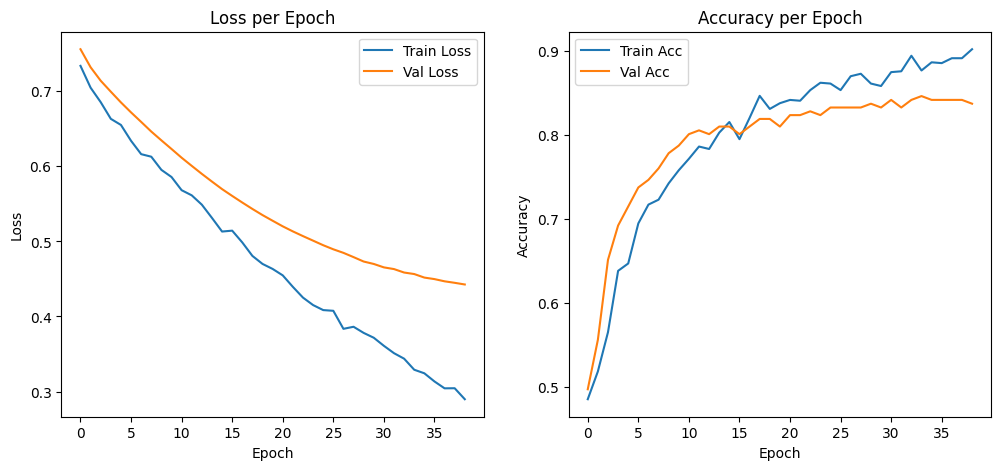

In [ ]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.show()

In [ ]:
#Fix
model_bert.eval()
all_preds = []
with torch.no_grad():
    for i in range(0, len(X_test_bert), batch_size):
        x_batch = X_test_bert[i:i+batch_size].to(device)
        outputs = model_bert(x_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())

print("Classification Report:")

# gunakan label encoder biar konsisten
labels = range(len(le.classes_))       # misalnya [0,1,2]
target_names = le.classes_             # misalnya ['negatif','netral','positif']

print(classification_report(
    y_test_bert.numpy(),
    all_preds,
    labels=labels,
    target_names=target_names,
    zero_division=0
))


Classification Report:
              precision    recall  f1-score   support

     negatif       0.80      0.87      0.84       117
     positif       0.84      0.76      0.80       104

    accuracy                           0.82       221
   macro avg       0.82      0.82      0.82       221
weighted avg       0.82      0.82      0.82       221



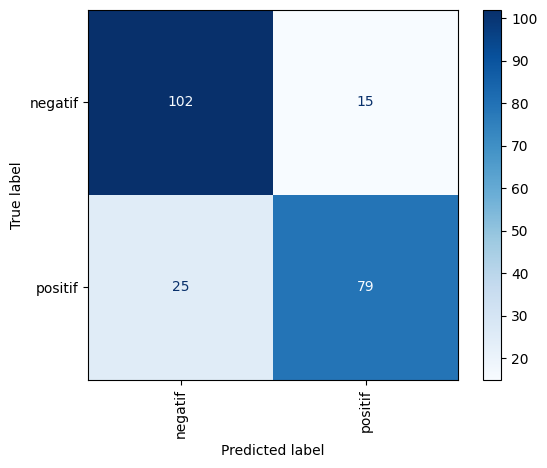

In [ ]:
labels = le.classes_   # ['negatif', 'netral', 'positif'] misalnya
y_true = y_test_bert.numpy()

conf_matrix = confusion_matrix(y_true, all_preds, labels=range(len(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)

disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.show()

In [ ]:
print(classification_report(
    y_test_bert.numpy(),
    all_preds,
    labels=labels,
    target_names=target_names,
    zero_division=0,
    digits=4    # <-- atur jumlah angka di belakang koma
))


In [ ]:
#Fix
model_bert.eval()
all_preds = []
with torch.no_grad():
    for i in range(0, len(X_test_bert), batch_size):
        x_batch = X_test_bert[i:i+batch_size].to(device)
        outputs = model_bert(x_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())

print("Classification Report:")

# gunakan label encoder biar konsisten
labels = range(len(le.classes_))       # misalnya [0,1,2]
target_names = le.classes_             # misalnya ['negatif','netral','positif']

print(classification_report(
    y_test_bert.numpy(),
    all_preds,
    labels=labels,
    target_names=target_names,
    zero_division=0,
    digits=4    # <-- atur jumlah angka di belakang koma
))


Classification Report:
              precision    recall  f1-score   support

     negatif     0.8031    0.8718    0.8361       117
     positif     0.8404    0.7596    0.7980       104

    accuracy                         0.8190       221
   macro avg     0.8218    0.8157    0.8170       221
weighted avg     0.8207    0.8190    0.8181       221

